## SETUP

In [ ]:
# install gridworld from pip
!pip install dezerogym

## ch04/dp.py

In [2]:
V = {'L1': 0.0, 'L2': 0.0}
new_V = V.copy()

cnt = 0
while True:
    new_V['L1'] = 0.5 * (-1 + 0.9 * V['L1']) + 0.5 * (1 + 0.9 * V['L2'])
    new_V['L2'] = 0.5 * (0 + 0.9 * V['L1']) + 0.5 * (-1 + 0.9 * V['L2'])

    delta = abs(new_V['L1'] - V['L1'])
    delta = max(delta, abs(new_V['L2'] - V['L2']))
    V = new_V.copy()

    cnt += 1
    if delta < 0.0001:
        print(V)
        print(cnt)
        break

{'L1': -2.249167525908671, 'L2': -2.749167525908671}
76


## ch04/dp_inplace.py

In [3]:
V = {'L1': 0.0, 'L2': 0.0}

cnt = 0
while True:
    t = 0.5 * (-1 + 0.9 * V['L1']) + 0.5 * (1 + 0.9 * V['L2'])
    delta = abs(t - V['L1'])
    V['L1'] = t

    t = 0.5 * (0 + 0.9 * V['L1']) + 0.5 * (-1 + 0.9 * V['L2'])
    delta = max(delta, abs(t - V['L2']))
    V['L2'] = t

    cnt += 1
    if delta < 0.0001:
        print(V)
        print(cnt)
        break

{'L1': -2.2493782177156936, 'L2': -2.7494201578106514}
60


## ch04/gridwolrd.py

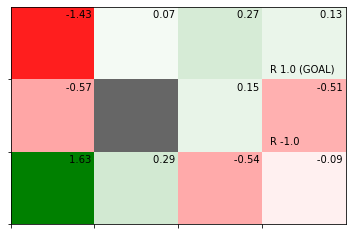

In [4]:
import numpy as np
from dezerogym.gridworld import GridWorld

env = GridWorld()
V = {}
for state in env.states():
    V[state] = np.random.randn()
env.render_v(V)

## ch04/policy_eval.py

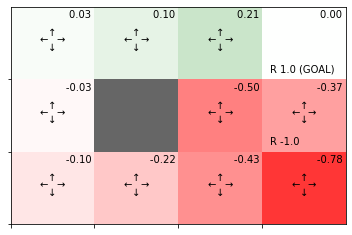

In [5]:
from collections import defaultdict
from dezerogym.gridworld import GridWorld


def eval_onestep(pi, V, env, gamma=0.9):
    for state in env.states():
        if state == env.goal_state:
            V[state] = 0
            continue

        action_probs = pi[state]
        new_V = 0
        for action, action_prob in action_probs.items():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            new_V += action_prob * (r + gamma * V[next_state])
        V[state] = new_V
    return V


def policy_eval(pi, V, env, gamma, threshold=0.001):
    while True:
        old_V = V.copy()
        V = eval_onestep(pi, V, env, gamma)

        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t

        if delta < threshold:
            break
    return V


env = GridWorld()
gamma = 0.9

pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
V = defaultdict(lambda: 0)

V = policy_eval(pi, V, env, gamma)
env.render_v(V, pi)

## ch04/policy_iter.py

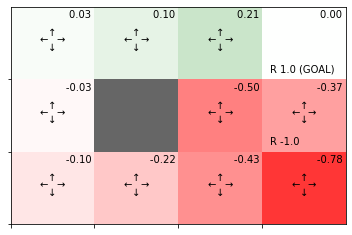

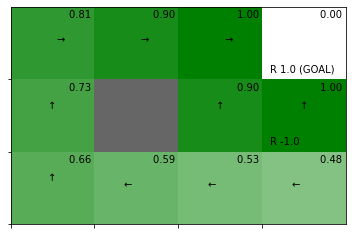

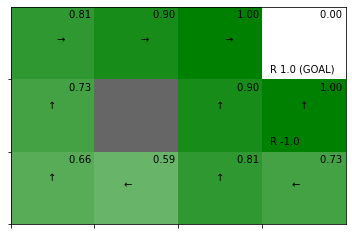

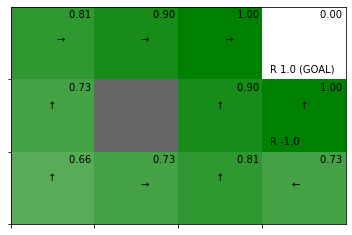

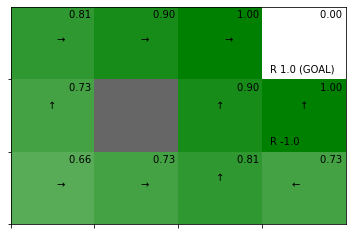

In [6]:
def argmax(d):
    """d (dict)"""
    max_value = max(d.values())
    max_key = -1
    for key, value in d.items():
        if value == max_value:
            max_key = key
    return max_key


def greedy_policy(V, env, gamma):
    pi = {}

    for state in env.states():
        action_values = {}

        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values[action] = value

        max_action = argmax(action_values)
        action_probs = {0: 0, 1: 0, 2: 0, 3: 0}
        action_probs[max_action] = 1.0
        pi[state] = action_probs
    return pi


def policy_iter(env, gamma, threshold=0.001, is_render=True):
    pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})
    V = defaultdict(lambda: 0)

    while True:
        V = policy_eval(pi, V, env, gamma, threshold)
        new_pi = greedy_policy(V, env, gamma)

        if is_render:
            env.render_v(V, pi)

        if new_pi == pi:
            break
        pi = new_pi

    return pi


env = GridWorld()
gamma = 0.9
pi = policy_iter(env, gamma)


## ch04/value_iter.py

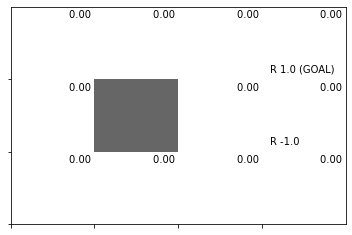

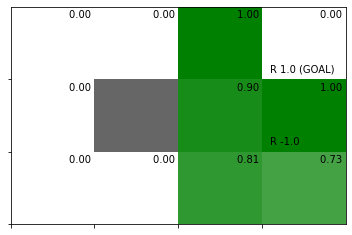

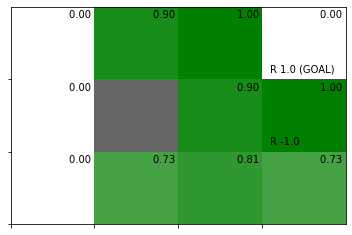

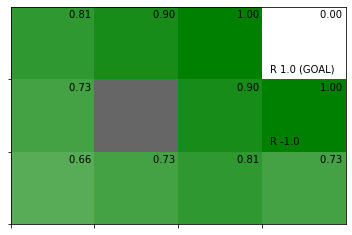

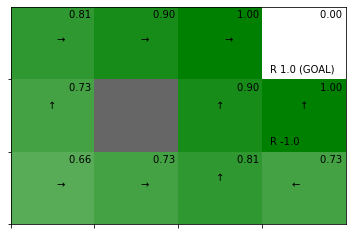

In [7]:
def value_iter_onestep(V, env, gamma):
    for state in env.states():
        if state == env.goal_state:
            V[state] = 0
            continue

        action_values = []
        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values.append(value)

        V[state] = max(action_values)
    return V


def value_iter(V, env, gamma, threshold=0.001, is_render=True):
    while True:
        if is_render:
            env.render_v(V)

        old_V = V.copy()
        V = value_iter_onestep(V, env, gamma)

        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t

        if delta < threshold:
            break
    return V


V = defaultdict(lambda: 0)
env = GridWorld()
gamma = 0.9

V = value_iter(V, env, gamma)

pi = greedy_policy(V, env, gamma)
env.render_v(V, pi)